# Ridge Map

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import colors
from matplotlib.collections import LineCollection

import py3dep
from pynhd import NLDI

In this tutorial, we use elevation contours to create a Ridge Map. A Ridge Map is a 2D representation of a 3D surface, where the ridges are shown as lines. The Ridge Map is created by finding the steepest ascent path from each point on the surface and plotting it as a line.

We modify a function from [Ridge Map](https://github.com/ColCarroll/ridge_map) to accept a `xarray.DataArray` as input and plot the Ridge Map using Matplotlib.

In [14]:
from typing import TYPE_CHECKING, Literal, cast

if TYPE_CHECKING:
    from matplotlib.axes import Axes
    from matplotlib.colors import Colormap
    from matplotlib.figure import Figure


def plot_ridges(
    elevation: xr.DataArray,
    label: str | None = None,
    label_x: float = 0.62,
    label_y: float = 0.15,
    label_verticalalignment: str = "bottom",
    label_size: int = 60,
    line_color: str | Colormap = "black",
    kind: Literal["gradient", "elevation"] = "gradient",
    linewidth: int = 2,
    background_color: tuple[float, float, float] = (0.9255, 0.9098, 0.9255),
    size_scale: int = 20,
) -> tuple[Figure, Axes]:
    """Plot the map.

    Notes
    -----
    This function is a modified version of the `plot_map` function from the
    `ridge_map <https://github.com/ColCarroll/ridge_map>`_ package.

    Parameters
    ----------
    elevation : xarray.DataArray
        Array of elevations to plot. Defaults to the elevations at the provided
        bounding box.
    label : str
        Label to place on the map. Use an empty string for no label.
    label_x : float in [0, 1]
        Where to position the label horizontally
    label_y : float in [0, 1]
        Where to position the label vertically
    label_verticalalignment: "top" or "bottom"
        Whether the label_x and label_y refer to the top or bottom left corner
        of the label text box
    label_size : int
        fontsize of the label
    line_color : str or callable
        colors for the map. A callable will be fed the scaled index in [0, 1]
    kind : {"gradient" | "elevation"}
        If you provide a colormap to ``line_color``, "gradient" colors by the line index, and
        "elevation" colors by the actual elevation along the line.
    linewidth : float
        Width of each line in the map
    background_color : color
        For the background of the map and figure
    scale_size : float
        If you are printing this, make this number bigger.

    Returns
    -------
    matplotlib.Axes
    """
    if kind not in {"gradient", "elevation"}:
        raise TypeError("Argument `kind` must be one of 'gradient' or 'elevation'")

    if not isinstance(elevation, xr.DataArray):
        raise TypeError("Argument `elevation` must be an xarray.DataArray")

    xmin, ymin, xmax, ymax = elevation.rio.bounds()
    ratio = (ymax - ymin) / (xmax - xmin)
    fig, ax = plt.subplots(figsize=(size_scale, size_scale * ratio))
    ax = cast("Axes", ax)

    values = elevation.to_numpy()
    x = np.arange(values.shape[1])
    norm = colors.Normalize(np.nanmin(values), np.nanmax(values))
    for idx, row in enumerate(values):
        y_base = -6 * idx * np.ones_like(row)
        y = row + y_base
        if callable(line_color) and kind == "elevation":
            points = np.array([x, y]).T.reshape((-1, 1, 2))
            segments = np.concatenate([points[:-1], points[1:]], axis=1).tolist()
            lines = LineCollection(segments, cmap=line_color, zorder=idx + 1, norm=norm)
            lines.set_array(row)
            lines.set_linewidth(linewidth)
            ax.add_collection(lines)
        else:
            if callable(line_color) and kind == "gradient":
                color = line_color(idx / values.shape[0])
            else:
                color = line_color

            ax.plot(x, y, "-", color=color, zorder=idx, lw=linewidth)
        ax.fill_between(x, y_base, y, color=background_color, zorder=idx)

    if label:
        ax.text(
            label_x,
            label_y,
            label,
            transform=ax.transAxes,
            size=label_size,
            verticalalignment=label_verticalalignment,
            bbox={"facecolor": background_color, "alpha": 1, "linewidth": 0},
            zorder=len(values) + 10,
        )

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_facecolor(background_color)
    return fig, ax

We get the DEM for station 01031500 by first getting its basin geometry from the NLDI web service from `pynhd` and then use `py3dep` to get the DEM at 90-m resolution.

In [15]:
geometry = NLDI().get_basins("01031500").geometry.iloc[0]
dem = py3dep.get_dem(geometry, 90)

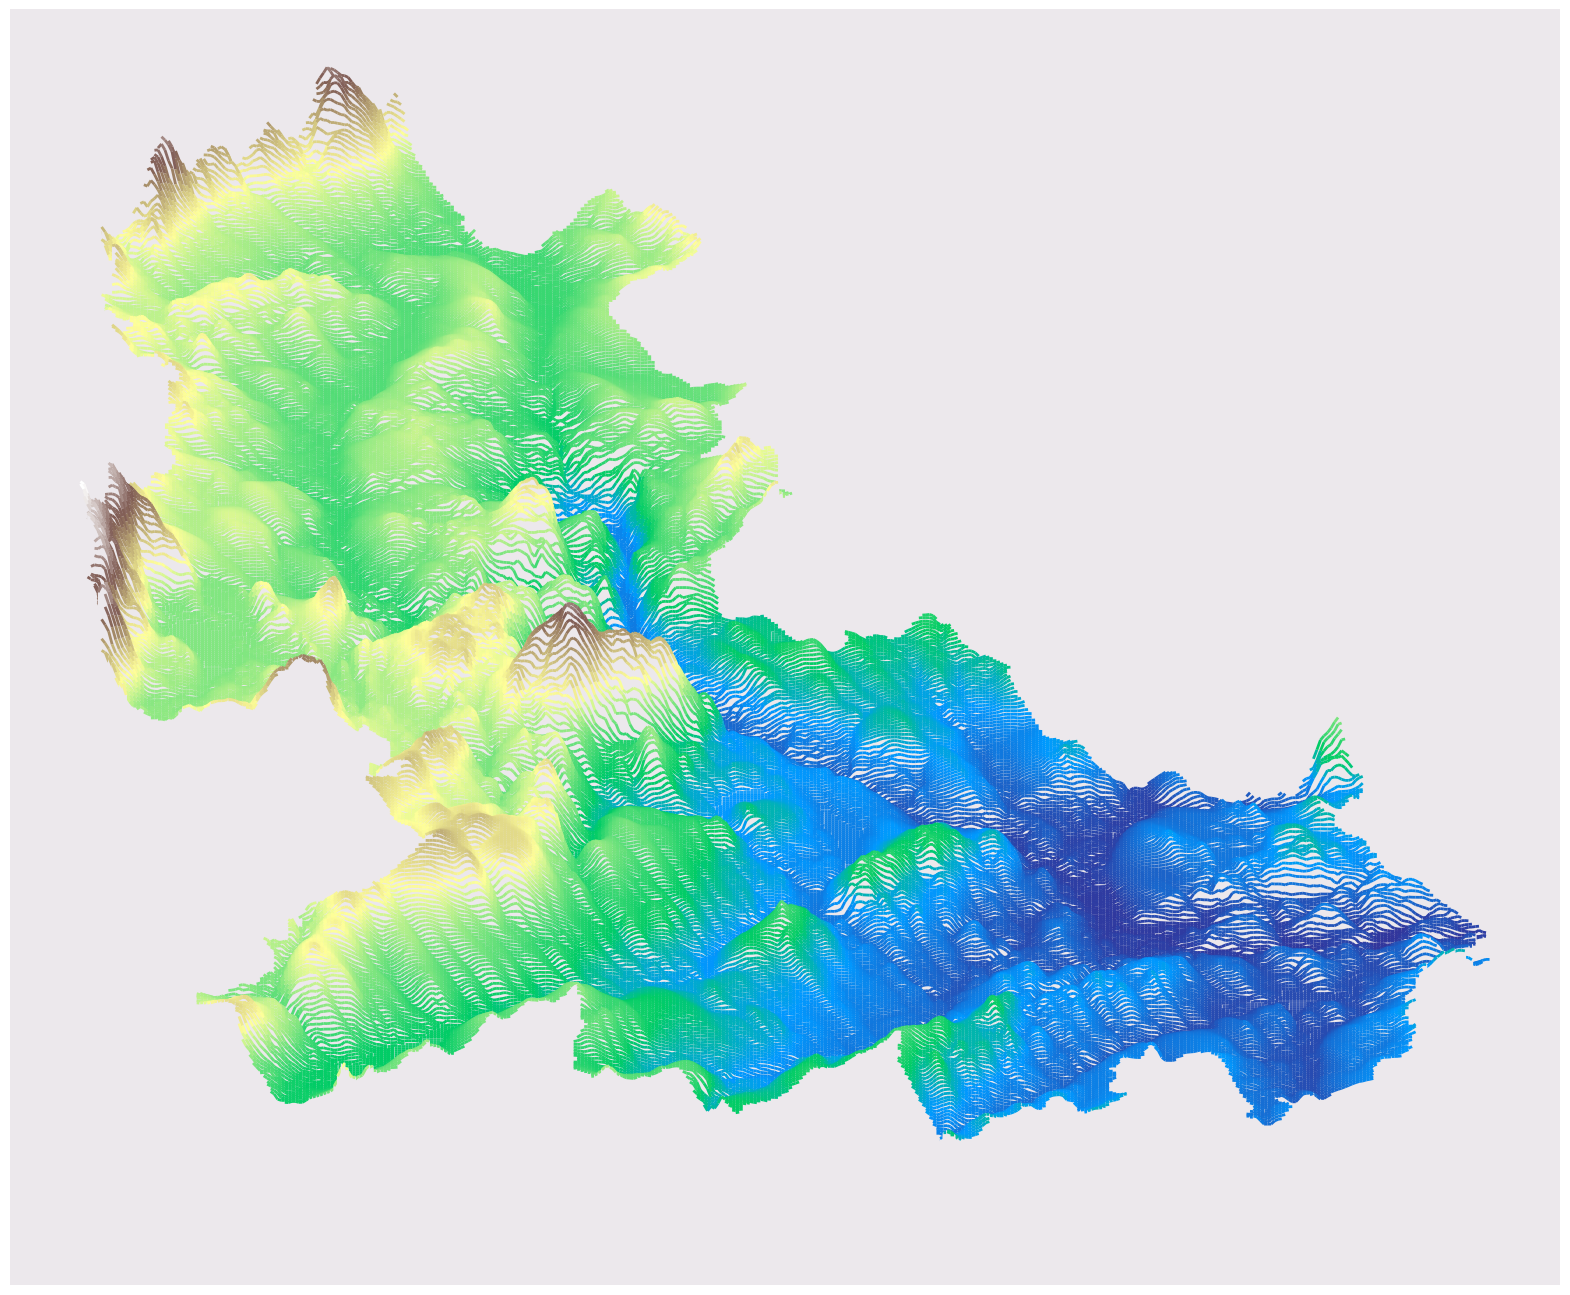

In [16]:
fig, _ = plot_ridges(dem, line_color=plt.get_cmap("terrain"), kind="elevation")
fig.savefig("_static/ridge_map.png", bbox_inches="tight", dpi=300)